<a href="https://colab.research.google.com/github/MonikaLamba/2-GeS/blob/main/cnn_80%2C10%2C10_CNN_BC_running.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=20

In [3]:
from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
dataset = '/content/drive/MyDrive/BC_CNN/DATA_BC'

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/BC_CNN/Data_BC',
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 322 files belonging to 7 classes.


In [6]:
class_names = dataset.class_names
class_names

['ARCH', 'ASYM', 'CALC', 'CIRC', 'MISC', 'NORM', 'SPIC']

In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[5 2 1 3 5 5 5 0 5 5 5 2 5 5 0 2 5 5 5 3 5 2 3 5 3 2 6 5 5 5 1 6]


In [8]:
len(dataset)

11

In [9]:
train_size = 0.8
len(dataset)*train_size

8.8

In [10]:
train_ds = dataset.take(62)
len(train_ds)

11

In [11]:
test_ds = dataset.skip(62)
len(test_ds)

0

In [12]:
val_size=0.1
len(dataset)*val_size

1.1

In [13]:
val_ds = test_ds.take(7)
len(val_ds)

0

In [14]:
test_ds = test_ds.take(7)
len(test_ds)

0

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    #assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

8

In [18]:
len(test_ds)

2

In [19]:
len(val_ds)

1

In [20]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])


In [22]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [23]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [24]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 1

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (2,2), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (2,2), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (2,2), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (2, 2), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((3, 3)),
    layers.Conv2D(64, (2, 2), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(n_classes, activation='sigmoid'),
])

model.build(input_shape=input_shape)


In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 255, 255, 32)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 126, 126, 64)        8256      
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 63, 63, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 62, 62, 64)         

In [26]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [27]:
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)
  

In [28]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
    callbacks =[earlystopping]
)


Epoch 1/20
8/8 [==============================] - 22s 2s/step - loss: -6.8861 - accuracy: 0.0469 - val_loss: -36.3855 - val_accuracy: 0.0625
Epoch 2/20
8/8 [==============================] - 12s 2s/step - loss: -235.2768 - accuracy: 0.0430 - val_loss: -843.1755 - val_accuracy: 0.0625
Epoch 3/20
8/8 [==============================] - 12s 2s/step - loss: -3515.2197 - accuracy: 0.0430 - val_loss: -11136.7900 - val_accuracy: 0.0625
Epoch 4/20
8/8 [==============================] - 12s 2s/step - loss: -36668.5781 - accuracy: 0.0430 - val_loss: -99214.0391 - val_accuracy: 0.0625
Epoch 5/20
8/8 [==============================] - 12s 2s/step - loss: -286141.2188 - accuracy: 0.0430 - val_loss: -656798.3750 - val_accuracy: 0.0625
Epoch 6/20
8/8 [==============================] - 12s 2s/step - loss: -1612064.8750 - accuracy: 0.0430 - val_loss: -3479558.7500 - val_accuracy: 0.0625
Epoch 7/20
8/8 [==============================] - 12s 2s/step - loss: -7711243.0000 - accuracy: 0.0430 - val_loss: -15

In [29]:
scores = model.evaluate(test_ds)

2/2 [==============================] - 3s 380ms/step - loss: -1128690089984.0000 - accuracy: 0.0625


In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

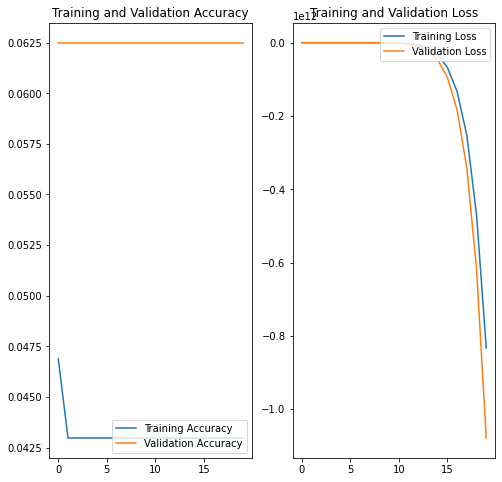

In [31]:
EPOCHS = 20

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: NORM
predicted label: ARCH
first image to predict
actual label: NORM
predicted label: ARCH
first image to predict
actual label: NORM
predicted label: ARCH
first image to predict
actual label: NORM
predicted label: ARCH
first image to predict
actual label: NORM
predicted label: ARCH
first image to predict
actual label: NORM
predicted label: ARCH


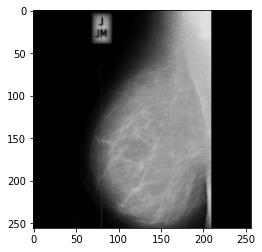

In [32]:
import numpy as np
for images_batch, labels_batch in test_ds.take(3):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[1])])
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[2])])

In [33]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


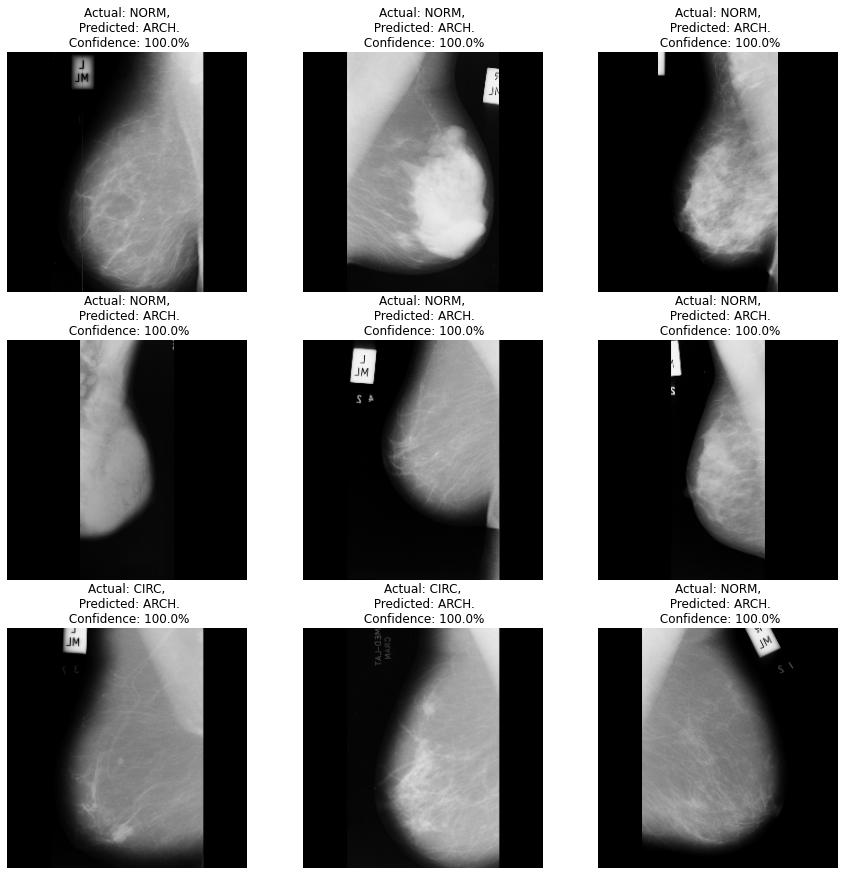

In [34]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")